## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Data Loading & Exploration

In [34]:
# Load the dataset
df = pd.read_csv('cleaned_player_data.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Number of Players: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")
df.head()

Dataset Shape: (5466, 132)
Number of Players: 5466
Number of Features: 132


,playerId,name,contractUntil,teamId,teamName,date_of_birth,age,height,preferredFoot,position,firstSidePosition,secondSidePosition,nationalityId,MarketValueCurrent,preferredFootId,positionId,firstSidePositionId,secondSidePositionId,MarketValuePrevious,MarketValueCurrency,player_name,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,expectedAssists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,goalsPrevented,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,expectedGoals,goalKicks,ballRecovery,id,type,appearances
0,561613,Joan García,2031-06-29 22:00:00.000000,131,FC Barcelona ~ 131,2001-05-04,24.0,1.94,right,Goalkeeper,NaN,NaN,157,30000000.0,2,1.0,NaN,NaN,25000000.0,EUR,Joan García,7.386842,280.7,38.0,0.0,0.0,0.0,0,0.066474,0.0,709.0,350.0,1059.0,66.949953,577.0,132.0,48.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,5.0,83.333333,23.0,95.833333,28.0,93.333333,3420.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,232.0,40.347826,39.0,2.0,2.0,0.0,360.0,0.0,92.0,52.0,1533.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,145.0,7.4865,8.0,6.0,2.0,88.0,54.0,43.0,8.0,21.0,20.0,19.0,60.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,575.0,51.0,0.0,0.000000,0.0,0.0,2.0,21.0,625.0,434.0,7.0,0.0741,216.0,392.0,1519597,overall,38
1,74857,Marc-André ter Stegen,2028-06-29 22:00:00.000000,131,FC Barcelona ~ 131,1992-04-30,33.0,1.87,right,Goalkeeper,NaN,NaN,40,7000000.0,2,1.0,NaN,NaN,8000000.0,EUR,Marc-André ter Stegen,6.812500,54.5,8.0,0.0,0.0,0.0,0,0.007278,0.0,193.0,18.0,211.0,91.469194,177.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,50.000000,2.0,100.000000,3.0,75.000000,675.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,62.790698,5.0,0.0,2.0,0.0,18.0,0.0,21.0,15.0,278.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.0,-2.1558,1.0,1.0,0.0,11.0,2.0,9.0,0.0,3.0,2.0,2.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,43.0,9.0,0.0,0.000000,0.0,0.0,0.0,1.0,184.0,27.0,0.0,0.0000,27.0,59.0,1513902,overall,8
2,44058,Wojciech Szczesny,2027-06-29 22:00:00.000000,131,FC Barcelona ~ 131,1990-04-18,35.0,1.95,right,Goalkeeper,NaN,NaN,135,900000.0,2,1.0,NaN,NaN,1000000.0,EUR,Wojciech Szczesny,6.913333,103.7,15.0,0.0,0.0,0.0,0,0.005652,0.0,342.0,49.0,391.0,87.468031,326.0,16.0,3.0,0.0,1.0,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,66.666667,1.0,100.000000,3.0,75.000000,1350.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,41.975309,23.0,1.0,0.0,0.0,52.0,0.0,20.0,11.0,511.0,1.0,1.0,0.0,0.0,0.0,0

In [35]:
# Check missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("Columns with Missing Values:")
print(missing_df)

Columns with Missing Values:
                      Missing Values  Percentage
secondSidePosition              3134   57.336261
secondSidePositionId            3134   57.336261
firstSidePosition               1589   29.070618
firstSidePositionId             1589   29.070618


## 3. Data Preprocessing

In [36]:
# Create a copy for processing
data = df.copy()

# Define target variable
TARGET = 'MarketValueCurrent'

# Columns to drop (non-predictive / redundant metadata)

cols_to_drop = [
    'teamId', 'playerID', 'playerId', 'player_name', 'name', 'date_of_birth',
    'MarketValueCurrency', 'id', 'type',
    'preferredFoot', 'teamName',
    'position', 'firstSidePosition', 'secondSidePosition', 'contractUntil'
]

data = data.drop(columns=cols_to_drop, errors='ignore')

print(f"Columns dropped: {len(cols_to_drop)}")
print(f"Dropped columns: {cols_to_drop}")
print(f"Remaining columns: {data.shape[1]}")

Columns dropped: 15
Dropped columns: ['teamId', 'playerID', 'playerId', 'player_name', 'name', 'date_of_birth', 'MarketValueCurrency', 'id', 'type', 'preferredFoot', 'teamName', 'position', 'firstSidePosition', 'secondSidePosition', 'contractUntil']
Remaining columns: 118


In [37]:
# Handle categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Columns: {categorical_cols}")

# Check unique values in categorical columns
for col in categorical_cols:
    print(f"\n{col}: {data[col].nunique()} unique values")
    print(data[col].value_counts().head(10))

Categorical Columns: []


In [38]:
# Encode categorical variables
label_encoders = {}

for col in categorical_cols:
    # Fill missing values with 'Unknown'
    data[col] = data[col].fillna('Unknown')
    
    # Label encode
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

print("Categorical columns encoded successfully!")
print(f"\nEncoded columns: {list(label_encoders.keys())}")

Categorical columns encoded successfully!

Encoded columns: []


In [39]:
data['firstSidePositionId'] = data['firstSidePositionId'].fillna(-1)
data['secondSidePositionId'] = data['secondSidePositionId'].fillna(-1)
data.loc[df['rating'] == 0, 'rating'] = data.loc[df['rating'] != 0, 'rating'].mean()

In [40]:
data

,age,height,nationalityId,MarketValueCurrent,preferredFootId,positionId,firstSidePositionId,secondSidePositionId,MarketValuePrevious,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,expectedAssists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,goalsPrevented,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,expectedGoals,goalKicks,ballRecovery,appearances
0,24.0,1.94,157,30000000.0,2,1.0,-1.0,-1.0,25000000.0,7.386842,280.7,38.0,0.0,0.0,0.0,0,0.066474,0.0,709.0,350.0,1059.0,66.949953,577.0,132.0,48.0,0.0,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,5.0,83.333333,23.0,95.833333,28.0,93.333333,3420.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,232.0,40.347826,39.0,2.0,2.0,0.0,360.0,0.0,92.0,52.0,1533.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,145.0,7.4865,8.0,6.0,2.0,88.0,54.0,43.0,8.0,21.0,20.0,19.0,60.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,575.0,51.0,0.0,0.000000,0.000000,0.0,2.0,21.0,625.0,434.0,7.0,0.0741,216.0,392.0,38
1,33.0,1.87,40,7000000.0,2,1.0,-1.0,-1.0,8000000.0,6.812500,54.5,8.0,0.0,0.0,0.0,0,0.007278,0.0,193.0,18.0,211.0,91.469194,177.0,16.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,50.000000,2.0,100.000000,3.0,75.000000,675.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,62.790698,5.0,0.0,2.0,0.0,18.0,0.0,21.0,15.0,278.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.0,-2.1558,1.0,1.0,0.0,11.0,2.0,9.0,0.0,3.0,2.0,2.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,43.0,9.0,0.0,0.000000,0.000000,0.0,0.0,1.0,184.0,27.0,0.0,0.0000,27.0,59.0,8
2,35.0,1.95,135,900000.0,2,1.0,-1.0,-1.0,1000000.0,6.913333,103.7,15.0,0.0,0.0,0.0,0,0.005652,0.0,342.0,49.0,391.0,87.468031,326.0,16.0,3.0,0.0,1.0,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,66.666667,1.0,100.000000,3.0,75.000000,1350.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,41.975309,23.0,1.0,0.0,0.0,52.0,0.0,20.0,11.0,511.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0526,8.0,1.0,0.0,16.0,5.0,12.0,0.0,3.0,25.0,25.0,6.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,81.0,12.0,1.0,100.000000,0.000000,0.0,0.0,6.0,345.0,46.0,0.0,0.0000,54.0,122.0,15
3,18.0,1.84,157,80000000.0,2,3.0,-1.0,-1.0,80000000.0,6.954286,243.4,35.0,0.0,3.0,1.0,3,0.951219,3.0,2426.0,165.0,2591.0,93.631802,1429.0,998.0,268.0,9.0,6.0,75.000000,34.0,16.0,3.0,0.0,0.0,1.0,50.000000,8.0,0.0,6.0,48.0,56.470588,63.0,58.333333,111.0,57.512953,2620.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,93.0,59.615385,86.0,

## 4. Feature Engineering

In [41]:
# Create new features

# 1. Goals per 90 minutes
data['goals_per_90'] = np.where(data['minutesPlayed'] > 0, 
                                 (data['goals'] / data['minutesPlayed']) * 90, 0)

# 2. Assists per 90 minutes
data['assists_per_90'] = np.where(data['minutesPlayed'] > 0, 
                                   (data['assists'] / data['minutesPlayed']) * 90, 0)

# 3. Goal involvement (goals + assists)
data['goal_involvement'] = data['goals'] + data['assists']

# 4. Goal involvement per 90
data['goal_involvement_per_90'] = np.where(data['minutesPlayed'] > 0,
                                            (data['goal_involvement'] / data['minutesPlayed']) * 90, 0)

# 5. Shots on target percentage
data['shots_on_target_pct'] = np.where(data['totalShots'] > 0,
                                        (data['shotsOnTarget'] / data['totalShots']) * 100, 0)

# 6. Big chances conversion rate
data['big_chance_conversion'] = np.where((data['bigChancesMissed'] + data['goals']) > 0,
                                          data['goals'] / (data['bigChancesMissed'] + data['goals']) * 100, 0)

# 7. Duels won per 90
data['duels_won_per_90'] = np.where(data['minutesPlayed'] > 0,
                                     (data['totalDuelsWon'] / data['minutesPlayed']) * 90, 0)

# 8. Touches per 90
data['touches_per_90'] = np.where(data['minutesPlayed'] > 0,
                                   (data['touches'] / data['minutesPlayed']) * 90, 0)

# 9. Key passes per 90
data['key_passes_per_90'] = np.where(data['minutesPlayed'] > 0,
                                      (data['keyPasses'] / data['minutesPlayed']) * 90, 0)

# 10. Successful dribbles per 90
data['dribbles_per_90'] = np.where(data['minutesPlayed'] > 0,
                                    (data['successfulDribbles'] / data['minutesPlayed']) * 90, 0)

# 11. Interceptions per 90
data['interceptions_per_90'] = np.where(data['minutesPlayed'] > 0,
                                         (data['interceptions'] / data['minutesPlayed']) * 90, 0)

# 12. Tackles per 90
data['tackles_per_90'] = np.where(data['minutesPlayed'] > 0,
                                   (data['tackles'] / data['minutesPlayed']) * 90, 0)

# 13. Clearances per 90
data['clearances_per_90'] = np.where(data['minutesPlayed'] > 0,
                                      (data['clearances'] / data['minutesPlayed']) * 90, 0)

# 14. Age squared (to capture non-linear age effects)
data['age_squared'] = data['age'] ** 2

# 15. Peak age indicator (typically 25-29 for football players)
data['is_peak_age'] = ((data['age'] >= 25) & (data['age'] <= 29)).astype(int)

# 16. Young talent indicator (under 23)
data['is_young_talent'] = (data['age'] < 23).astype(int)

# 17. Rating difference from average
data['rating_diff'] = data['rating'] - data['rating'].mean()

# 18. Minutes per appearance
data['minutes_per_appearance'] = np.where(data['appearances'] > 0,
                                        data['minutesPlayed'] / data['appearances'], 0)

# 19. Passes per 90
data['passes_per_90'] = np.where(data['minutesPlayed'] > 0,
                                  (data['totalPasses'] / data['minutesPlayed']) * 90, 0)

print(f"New features created! Total features now: {data.shape[1]}")
print(f"\nNew feature columns:")
new_features = ['goals_per_90', 'assists_per_90', 'goal_involvement', 'goal_involvement_per_90',
                'shots_on_target_pct', 'big_chance_conversion', 'duels_won_per_90', 'touches_per_90',
                'key_passes_per_90', 'dribbles_per_90', 'interceptions_per_90', 'tackles_per_90',
                'clearances_per_90', 'age_squared', 'is_peak_age', 'is_young_talent', 'rating_diff',
                'minutes_per_appearance', 'passes_per_90']
print(new_features)

New features created! Total features now: 137

New feature columns:
['goals_per_90', 'assists_per_90', 'goal_involvement', 'goal_involvement_per_90', 'shots_on_target_pct', 'big_chance_conversion', 'duels_won_per_90', 'touches_per_90', 'key_passes_per_90', 'dribbles_per_90', 'interceptions_per_90', 'tackles_per_90', 'clearances_per_90', 'age_squared', 'is_peak_age', 'is_young_talent', 'rating_diff', 'minutes_per_appearance', 'passes_per_90']


In [42]:
# Handle infinite values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

print(f"Final dataset shape: {data.shape}")
print(f"Total missing values: {data.isnull().sum().sum()}")

Final dataset shape: (5466, 137)
Total missing values: 0


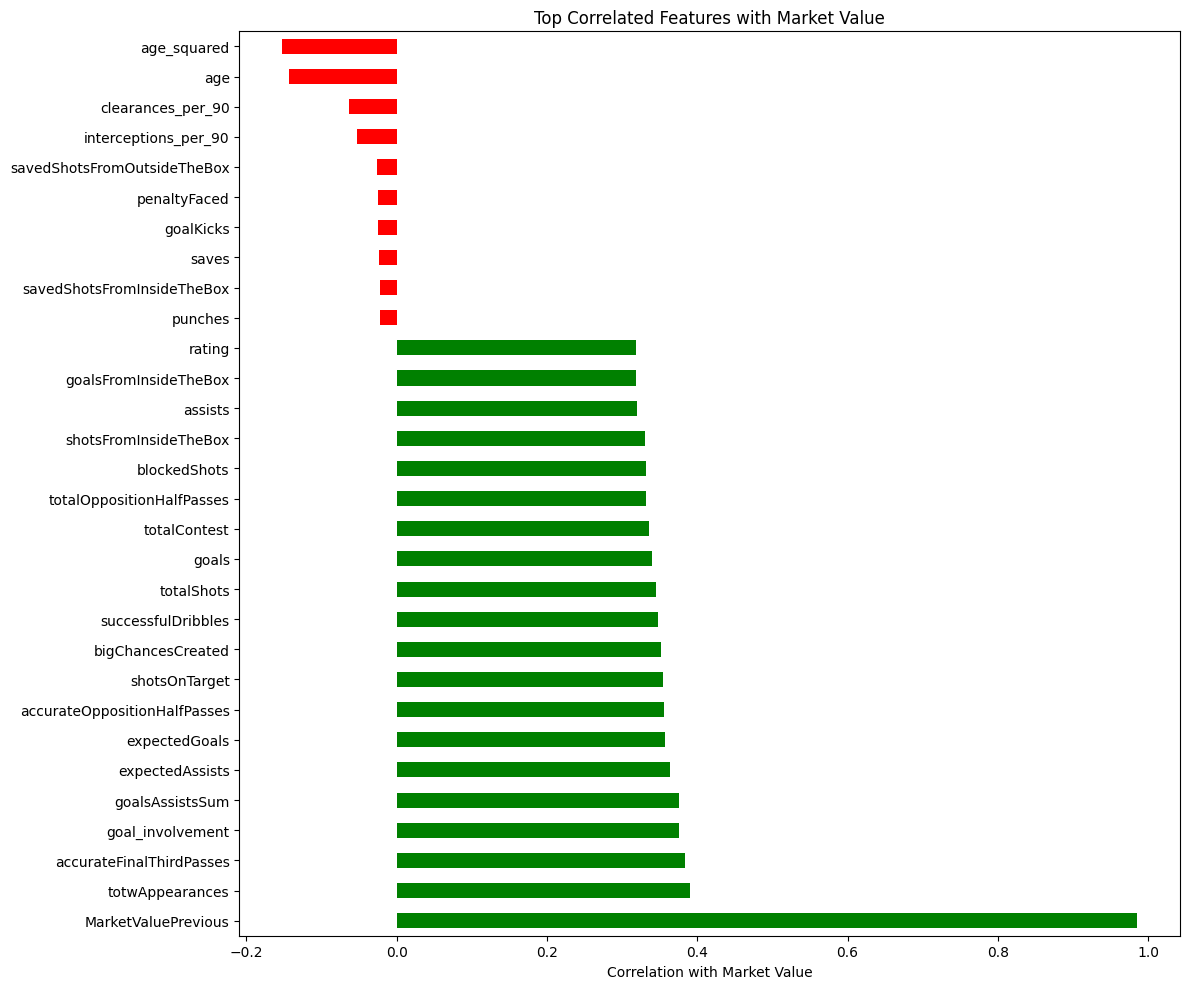


Top 15 Positively Correlated Features:
MarketValuePrevious             0.985479
totwAppearances                 0.390309
accurateFinalThirdPasses        0.383334
goal_involvement                0.376171
goalsAssistsSum                 0.376171
expectedAssists                 0.364250
expectedGoals                   0.357585
accurateOppositionHalfPasses    0.355064
shotsOnTarget                   0.354610
bigChancesCreated               0.351844
successfulDribbles              0.347467
totalShots                      0.345362
goals                           0.339263
totalContest                    0.335282
totalOppositionHalfPasses       0.331724
Name: MarketValueCurrent, dtype: float64

Top 10 Negatively Correlated Features:
punches                       -0.022337
savedShotsFromInsideTheBox    -0.022779
saves                         -0.023815
goalKicks                     -0.024601
penaltyFaced                  -0.025438
savedShotsFromOutsideTheBox   -0.025912
interceptions_per_90    

In [43]:
# Correlation analysis with target
correlations = data.corr()[TARGET].drop(TARGET).sort_values(ascending=False)

# Plot top correlations
plt.figure(figsize=(12, 10))
top_corr = pd.concat([correlations.head(20), correlations.tail(10)])
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
top_corr.plot(kind='barh', color=colors)
plt.xlabel('Correlation with Market Value')
plt.title('Top Correlated Features with Market Value')
plt.tight_layout()
plt.show()

print("\nTop 15 Positively Correlated Features:")
print(correlations.head(15))
print("\nTop 10 Negatively Correlated Features:")
print(correlations.tail(10))

## 5. Train/Validation/Test Split

In [44]:
# Prepare features and target
data['delta'] = np.log1p(data['MarketValueCurrent']) - np.log1p(data['MarketValuePrevious'])
TARGET = 'delta'

values_df = data[['MarketValuePrevious', 'MarketValueCurrent']].copy()
# Drop the columns from the original DataFrame
data.drop(columns=['MarketValuePrevious', 'MarketValueCurrent'], inplace=True)

feature_cols = [col for col in data.columns if col not in [TARGET]]

X = data[feature_cols]
y = data[TARGET]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {len(feature_cols)}")

X

Features shape: (5466, 135)
Target shape: (5466,)

Number of features: 135


,age,height,nationalityId,preferredFootId,positionId,firstSidePositionId,secondSidePositionId,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,expectedAssists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,goalsPrevented,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,expectedGoals,goalKicks,ballRecovery,appearances,goals_per_90,assists_per_90,goal_involvement,goal_involvement_per_90,shots_on_target_pct,big_chance_conversion,duels_won_per_90,touches_per_90,key_passes_per_90,dribbles_per_90,interceptions_per_90,tackles_per_90,clearances_per_90,age_squared,is_peak_age,is_young_talent,rating_diff,minutes_per_appearance,passes_per_90
0,24.0,1.94,157,2,1.0,-1.0,-1.0,7.386842,280.7,38.0,0.0,0.0,0.0,0,0.066474,0.0,709.0,350.0,1059.0,66.949953,577.0,132.0,48.0,0.0,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,5.0,83.333333,23.0,95.833333,28.0,93.333333,3420.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,232.0,40.347826,39.0,2.0,2.0,0.0,360.0,0.0,92.0,52.0,1533.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,145.0,7.4865,8.0,6.0,2.0,88.0,54.0,43.0,8.0,21.0,20.0,19.0,60.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,575.0,51.0,0.0,0.000000,0.000000,0.0,2.0,21.0,625.0,434.0,7.0,0.0741,216.0,392.0,38,0.000000,0.000000,0.0,0.000000,100.000000,0.000000,0.736842,40.342105,0.000000,0.000000,0.000000,0.000000,1.026316,576.0,0,0,0.504921,90.000000,27.868421
1,33.0,1.87,40,2,1.0,-1.0,-1.0,6.812500,54.5,8.0,0.0,0.0,0.0,0,0.007278,0.0,193.0,18.0,211.0,91.469194,177.0,16.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,50.000000,2.0,100.000000,3.0,75.000000,675.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,62.790698,5.0,0.0,2.0,0.0,18.0,0.0,21.0,15.0,278.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.0,-2.1558,1.0,1.0,0.0,11.0,2.0,9.0,0.0,3.0,2.0,2.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,43.0,9.0,0.0,0.000000,0.000000,0.0,0.0,1.0,184.0,27.0,0.0,0.0000,27.0,59.0,8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,37.066667,0.000000,0.000000,0.000000,0.000000,0.666667,1089.0,0,0,-0.069421,84.375000,28.133333
2,35.0,1.95,135,2,1.0,-1.0,-1.0,6.913333,103.7,15.0,0.0,0.0,0.0,0,0.005652,0.0,342.0,49.0,391.0,87.468031,326.0,16.0,3.0,0.0,1.0,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,66.666667,1.0,100.000000,3.0,75.000000,1350.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,41.975309,23.0,1.0,0.0,0.0,52.0,0.0,20.0,11.0,511.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0526,8

In [91]:
# Split data: 80% Train and Validation, 20% Test
X_train, X_test, y_train, y_test, values_df_train, values_df_test = train_test_split(
    X, y, values_df, test_size=0.20, random_state=42
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

Training set size: 4372 (80.0%)
Test set size: 1094 (20.0%)


In [123]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')
values_df_train.to_csv('values_df_train.csv')
values_df_test.to_csv('values_df_test.csv')

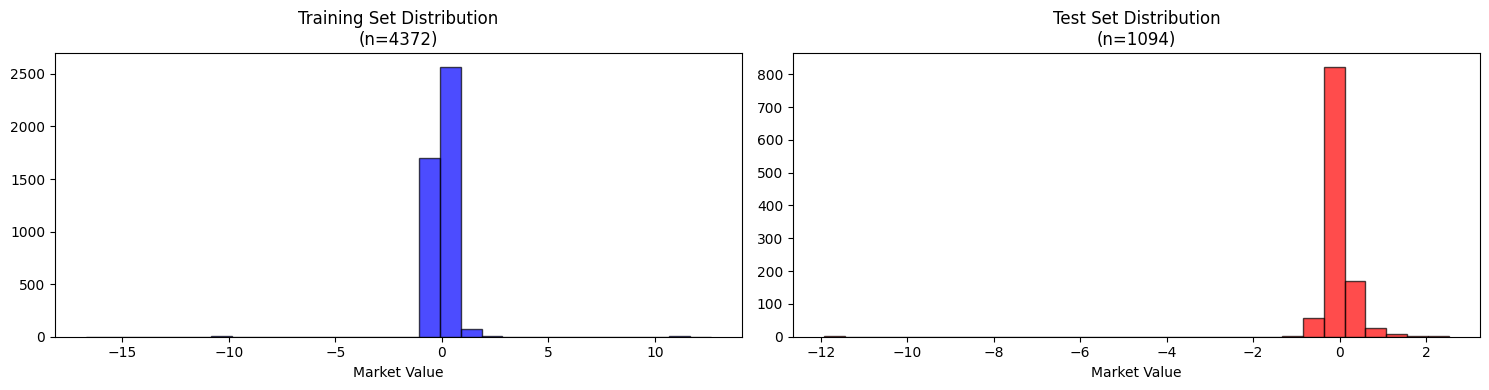

In [46]:
# Verify the splits have similar distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title(f'Training Set Distribution\n(n={len(y_train)})')
axes[0].set_xlabel('Market Value')

axes[1].hist(y_test, bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1].set_title(f'Test Set Distribution\n(n={len(y_test)})')
axes[1].set_xlabel('Market Value')

plt.tight_layout()
plt.show()

## 6. Model Training with Hyperparameter Tuning

In [47]:
# Define evaluation functions
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""    
    # Metrics on original scale
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{'='*50}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*50}")
    print(f"  RMSE: €{rmse:,.0f}")
    print(f"  MAE: €{mae:,.0f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

def plot_predictions(y_true, y_pred, model_name):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=10)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Market Value (EUR)')
    plt.ylabel('Predicted Market Value (EUR)')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
def eval_new(delta_pred_org, df, model_name):
    pred = delta_pred_org.flatten()
    
    # 1. Get Previous Value in Log Scale
    prev_log = np.log1p(df['MarketValuePrevious'])
    
    # 2. Add Predicted Log Difference
    current_pred_log = prev_log + pred
    
    # 3. Convert back to Original Scale (Inverse Log)
    df['Predicted'] = np.expm1(current_pred_log)
    
    # --- Metrics on Log Scale ---
    actual_log = np.log1p(df['MarketValueCurrent'])
    rmse_log = np.sqrt(mean_squared_error(actual_log, current_pred_log))
    mae_log = mean_absolute_error(actual_log, current_pred_log)
    r2_log = r2_score(actual_log, current_pred_log)
    
    # print(df[df['MarketValueCurrent'] == 0])
    y_org = df['MarketValueCurrent'].copy()
    y_pred_org = df['Predicted'].copy()

    y_org.replace(0, 1, inplace=True)
    # y_org.fillna(y_org.mean(), inplace=True)
    
    # Metrics on original scale
    rmse = np.sqrt(mean_squared_error(y_org, y_pred_org))
    mae = mean_absolute_error(y_org, y_pred_org)
    r2 = r2_score(y_org, y_pred_org)
    mape = mean_absolute_percentage_error(y_org, y_pred_org) * 100
    
    print(f"\n{'='*50}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*50}")
    print(f"  Log RMSE: {rmse_log:.4f}")
    print(f"  Log MAE:  {mae_log:.4f}")
    print(f"  Log R²:   {r2_log:.4f}")
    print(f"{'-'*50}")
    print(f"  RMSE: €{rmse:,.0f}")
    print(f"  MAE: €{mae:,.0f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'r2_log': r2_log
    }

### 6.1 XGBoost Model

In [49]:
# XGBoost Hyperparameter Tuning
print("Training XGBoost with Hyperparameter Tuning...")

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 1.0]
}

xgb_base = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

xgb_random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random_search.fit(X_train, y_train)

print(f"\nBest XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best CV Score (RMSE): {-xgb_random_search.best_score_:.4f}")

Training XGBoost with Hyperparameter Tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best XGBoost Parameters: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV Score (RMSE): 0.8007


### 6.2 LightGBM Model

In [50]:
# LightGBM Hyperparameter Tuning
print("Training LightGBM with Hyperparameter Tuning...")

lgbm_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63, 127],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [5, 10, 20],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 1.0]
}

lgbm_base = LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)

lgbm_random_search = RandomizedSearchCV(
    lgbm_base,
    param_distributions=lgbm_param_grid,
    n_iter=50, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgbm_random_search.fit(X_train, y_train)

print(f"\nBest LightGBM Parameters: {lgbm_random_search.best_params_}")
print(f"Best CV Score (RMSE): {-lgbm_random_search.best_score_:.4f}")

Training LightGBM with Hyperparameter Tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best LightGBM Parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0, 'num_leaves': 63, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV Score (RMSE): 0.8048


### 6.3 CatBoost Model

In [51]:
# CatBoost Hyperparameter Tuning
print("Training CatBoost with Hyperparameter Tuning...")

catboost_param_grid = {
    'iterations': [100, 200, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0, 0.5, 1],
    'border_count': [32, 64, 128]
}

catboost_base = CatBoostRegressor(
    random_state=42,
    verbose=0,
    thread_count=-1,
)

catboost_random_search = RandomizedSearchCV(
    catboost_base,
    param_distributions=catboost_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

catboost_random_search.fit(X_train, y_train)

print(f"\nBest CatBoost Parameters: {catboost_random_search.best_params_}")
print(f"Best CV Score (RMSE): {-catboost_random_search.best_score_:.4f}")

Training CatBoost with Hyperparameter Tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CatBoost Parameters: {'random_strength': 1, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 6, 'border_count': 32, 'bagging_temperature': 0.5}
Best CV Score (RMSE): 0.7993


## 7. Final Evaluation on Test Set

In [53]:
# BASE

# Evaluate all models on the test set
print("\n" + "="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

# XGBoost Test Predictions
xgb_best = xgb_random_search.best_estimator_
y_test_pred_xgb = xgb_best.predict(X_test)
xgb_test_results = eval_new(y_test_pred_xgb, values_df_test, "XGBoost")
y_pred_xgb_original = values_df_test['Predicted'].copy()

# LightGBM Test Predictions
lgbm_best = lgbm_random_search.best_estimator_
y_test_pred_lgbm = lgbm_best.predict(X_test)
lgbm_test_results = eval_new(y_test_pred_lgbm, values_df_test, "LightGBM")
y_pred_lgbm_original = values_df_test['Predicted'].copy()

# CatBoost Test Predictions
catboost_best = catboost_random_search.best_estimator_
y_test_pred_catboost = catboost_best.predict(X_test)
catboost_test_results = eval_new(y_test_pred_catboost, values_df_test, "CatBoost")
y_pred_catboost_original = values_df_test['Predicted'].copy()


FINAL EVALUATION ON TEST SET

XGBoost Evaluation Results
  Log RMSE: 0.5740
  Log MAE:  0.2088
  Log R²:   0.8862
--------------------------------------------------
  RMSE: €2,140,590
  MAE: €950,920
  R²: 0.9722
  MAPE: 23445.88%

LightGBM Evaluation Results
  Log RMSE: 0.5773
  Log MAE:  0.2157
  Log R²:   0.8849
--------------------------------------------------
  RMSE: €2,177,371
  MAE: €966,655
  R²: 0.9712
  MAPE: 23751.68%

CatBoost Evaluation Results
  Log RMSE: 0.5752
  Log MAE:  0.2061
  Log R²:   0.8857
--------------------------------------------------
  RMSE: €2,123,535
  MAE: €918,905
  R²: 0.9726
  MAPE: 24669.89%


In [122]:
import joblib
joblib.dump(xgb_best, 'xgb_model.pkl')
joblib.dump(lgbm_best, 'lgbm_model.pkl')
joblib.dump(catboost_best, 'catboost_model.pkl')

['catboost_model.pkl']

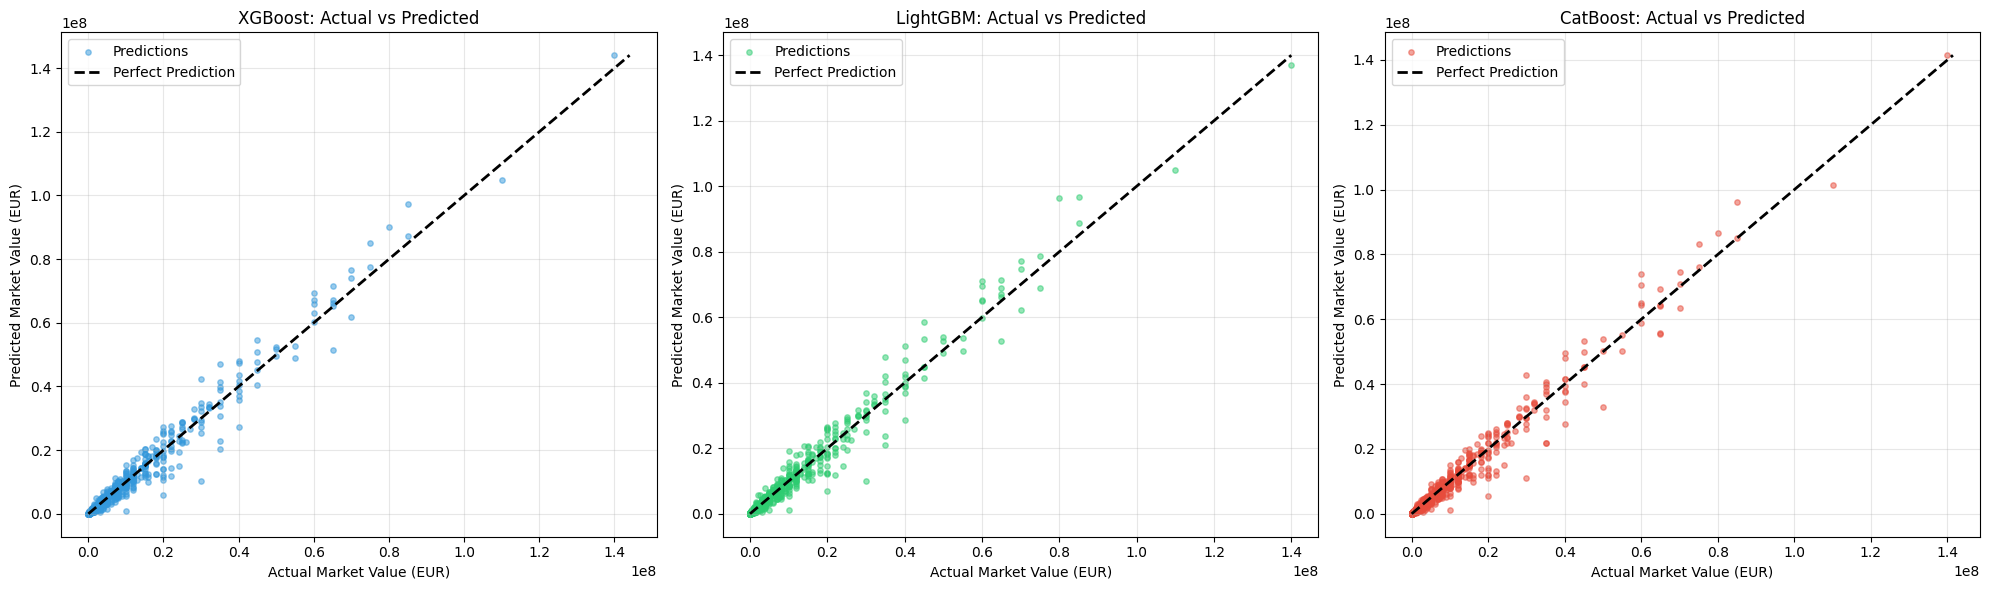

In [54]:
# Visualization of predictions vs actual for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

y_test_original = values_df_test['MarketValueCurrent']

predictions = [
    (y_pred_xgb_original, 'XGBoost', '#3498db'),
    (y_pred_lgbm_original, 'LightGBM', '#2ecc71'),
    (y_pred_catboost_original, 'CatBoost', '#e74c3c')
]

for ax, (y_pred, name, color) in zip(axes, predictions):
    # Scatter plot
    ax.scatter(y_test_original, y_pred, alpha=0.5, s=15, c=color, label='Predictions')
    
    # Perfect prediction line
    min_val = min(y_test_original.min(), y_pred.min())
    max_val = max(y_test_original.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    # Formatting
    ax.set_xlabel('Actual Market Value (EUR)')
    ax.set_ylabel('Predicted Market Value (EUR)')
    ax.set_title(f'{name}: Actual vs Predicted')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Forward Feature Selection for XGBoost, LightGBM, CatBoost

In [95]:
# Function to perform forward selection with progression tracking
def forward_selection_with_progression(estimator, X_train, y_train, X_test, y_test, values_test, model_name, max_features=30):
    """
    Performs forward feature selection and tracks performance at each step.
    Returns selected features and progression data.
    """
    selected_features = []
    remaining_features = list(X_train.columns)
    
    progression = {
        'n_features': [],
        'feature_added': [],
        'r2': [],
        'rmse': []
    }
    
    print(f"\nPerforming forward selection for {model_name}...")
    
    for i in range(max_features):
        best_score = -np.inf
        best_feature = None
        
        for feature in remaining_features:
            # Try adding this feature
            test_features = selected_features + [feature]
            
            # Train and evaluate
            model = estimator
            model.fit(X_train[test_features], y_train)
            pred = model.predict(X_test[test_features])
            
            # Calculate score (using R²)
            values_copy = values_test.copy()
            prev_log = np.log1p(values_copy['MarketValuePrevious'])
            current_pred_log = prev_log + pred
            values_copy['Predicted'] = np.expm1(current_pred_log)
            
            y_actual = values_copy['MarketValueCurrent'].replace(0, 1)
            y_pred = values_copy['Predicted']
            score = r2_score(y_actual, y_pred)
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        # Add best feature
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            
            # Calculate metrics with current feature set
            model = estimator
            model.fit(X_train[selected_features], y_train)
            pred = model.predict(X_test[selected_features])
            
            values_copy = values_test.copy()
            prev_log = np.log1p(values_copy['MarketValuePrevious'])
            current_pred_log = prev_log + pred
            values_copy['Predicted'] = np.expm1(current_pred_log)
            
            y_actual = values_copy['MarketValueCurrent'].replace(0, 1)
            y_pred = values_copy['Predicted']
            
            r2 = r2_score(y_actual, y_pred)
            rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
            
            progression['n_features'].append(len(selected_features))
            progression['feature_added'].append(best_feature)
            progression['r2'].append(r2)
            progression['rmse'].append(rmse)
            
            print(f"  Step {i+1}: Added '{best_feature}' | R² = {r2:.4f} | RMSE = {rmse:,.0f}")
    
    return selected_features, pd.DataFrame(progression), model


In [92]:
X_train, X_val, y_train, y_val, values_df_train_fs, values_df_valid_fs = train_test_split(X_train, y_train, values_df_train, test_size=0.2, random_state=42)

In [97]:
# XGBoost Forward Selection Progression
xgb_model = XGBRegressor(**xgb_random_search.best_params_, random_state=42, n_jobs=-1, verbosity=0)
xgb_selected, xgb_progression, xgb_fs_model = forward_selection_with_progression(
    xgb_model, X_train, y_train, X_val, y_val, 
    values_df_valid_fs.copy(), "XGBoost", max_features=30
)


Performing forward selection for XGBoost...
  Step 1: Added 'secondSidePositionId' | R² = 0.9685 | RMSE = 2,395,218
  Step 2: Added 'interceptions_per_90' | R² = 0.9690 | RMSE = 2,378,014
  Step 3: Added 'goalsConcededInsideTheBox' | R² = 0.9692 | RMSE = 2,372,045
  Step 4: Added 'shots_on_target_pct' | R² = 0.9710 | RMSE = 2,301,086
  Step 5: Added 'penaltyWon' | R² = 0.9722 | RMSE = 2,252,650
  Step 6: Added 'preferredFootId' | R² = 0.9719 | RMSE = 2,263,903
  Step 7: Added 'tacklesWonPercentage' | R² = 0.9730 | RMSE = 2,218,923
  Step 8: Added 'attemptPenaltyTarget' | R² = 0.9733 | RMSE = 2,205,507
  Step 9: Added 'saves' | R² = 0.9730 | RMSE = 2,217,838
  Step 10: Added 'savedShotsFromOutsideTheBox' | R² = 0.9728 | RMSE = 2,227,215
  Step 11: Added 'goalKicks' | R² = 0.9735 | RMSE = 2,197,527
  Step 12: Added 'shotFromSetPiece' | R² = 0.9734 | RMSE = 2,200,930
  Step 13: Added 'accurateCrossesPercentage' | R² = 0.9725 | RMSE = 2,240,563
  Step 14: Added 'rating' | R² = 0.9731 | RM

In [98]:
# LightGBM Forward Selection Progression
lgbm_model = LGBMRegressor(**lgbm_random_search.best_params_, random_state=42, n_jobs=-1, verbosity=-1)
lgbm_selected, lgbm_progression, lgbm_fs_model = forward_selection_with_progression(
    lgbm_model, X_train, y_train, X_val, y_val,
    values_df_valid_fs.copy(), "LightGBM", max_features=30
)


Performing forward selection for LightGBM...
  Step 1: Added 'secondSidePositionId' | R² = 0.9689 | RMSE = 2,381,477
  Step 2: Added 'hitWoodwork' | R² = 0.9696 | RMSE = 2,353,900
  Step 3: Added 'attemptPenaltyMiss' | R² = 0.9696 | RMSE = 2,353,900
  Step 4: Added 'attemptPenaltyPost' | R² = 0.9696 | RMSE = 2,353,900
  Step 5: Added 'is_peak_age' | R² = 0.9694 | RMSE = 2,362,181
  Step 6: Added 'penaltyConceded' | R² = 0.9696 | RMSE = 2,353,269
  Step 7: Added 'preferredFootId' | R² = 0.9692 | RMSE = 2,368,787
  Step 8: Added 'savedShotsFromOutsideTheBox' | R² = 0.9702 | RMSE = 2,331,461
  Step 9: Added 'passToAssist' | R² = 0.9702 | RMSE = 2,331,646
  Step 10: Added 'savesParried' | R² = 0.9705 | RMSE = 2,320,621
  Step 11: Added 'yellowRedCards' | R² = 0.9705 | RMSE = 2,320,427
  Step 12: Added 'attemptPenaltyTarget' | R² = 0.9706 | RMSE = 2,316,804
  Step 13: Added 'errorLeadToGoal' | R² = 0.9705 | RMSE = 2,320,572
  Step 14: Added 'runsOut' | R² = 0.9703 | RMSE = 2,326,157
  Step

In [99]:
# CatBoost Forward Selection Progression
catboost_model = CatBoostRegressor(**catboost_random_search.best_params_, random_state=42, verbose=0)
catboost_selected, catboost_progression, catboost_fs_model = forward_selection_with_progression(
    catboost_model, X_train, y_train, X_val, y_val,
    values_df_valid_fs.copy(), "CatBoost", max_features=30
)


Performing forward selection for CatBoost...
  Step 1: Added 'shotFromSetPiece' | R² = 0.9677 | RMSE = 2,427,172
  Step 2: Added 'touches_per_90' | R² = 0.9686 | RMSE = 2,392,712
  Step 3: Added 'setPieceConversion' | R² = 0.9690 | RMSE = 2,377,220
  Step 4: Added 'crossesNotClaimed' | R² = 0.9692 | RMSE = 2,369,592
  Step 5: Added 'freeKickGoal' | R² = 0.9689 | RMSE = 2,379,985
  Step 6: Added 'is_peak_age' | R² = 0.9690 | RMSE = 2,377,049
  Step 7: Added 'accurateCrossesPercentage' | R² = 0.9694 | RMSE = 2,363,067
  Step 8: Added 'totalDuelsWonPercentage' | R² = 0.9701 | RMSE = 2,335,423
  Step 9: Added 'positionId' | R² = 0.9705 | RMSE = 2,319,406
  Step 10: Added 'redCards' | R² = 0.9701 | RMSE = 2,333,618
  Step 11: Added 'passToAssist' | R² = 0.9704 | RMSE = 2,322,753
  Step 12: Added 'savesCaught' | R² = 0.9702 | RMSE = 2,329,992
  Step 13: Added 'penaltySave' | R² = 0.9699 | RMSE = 2,343,773
  Step 14: Added 'preferredFootId' | R² = 0.9700 | RMSE = 2,337,827
  Step 15: Added '

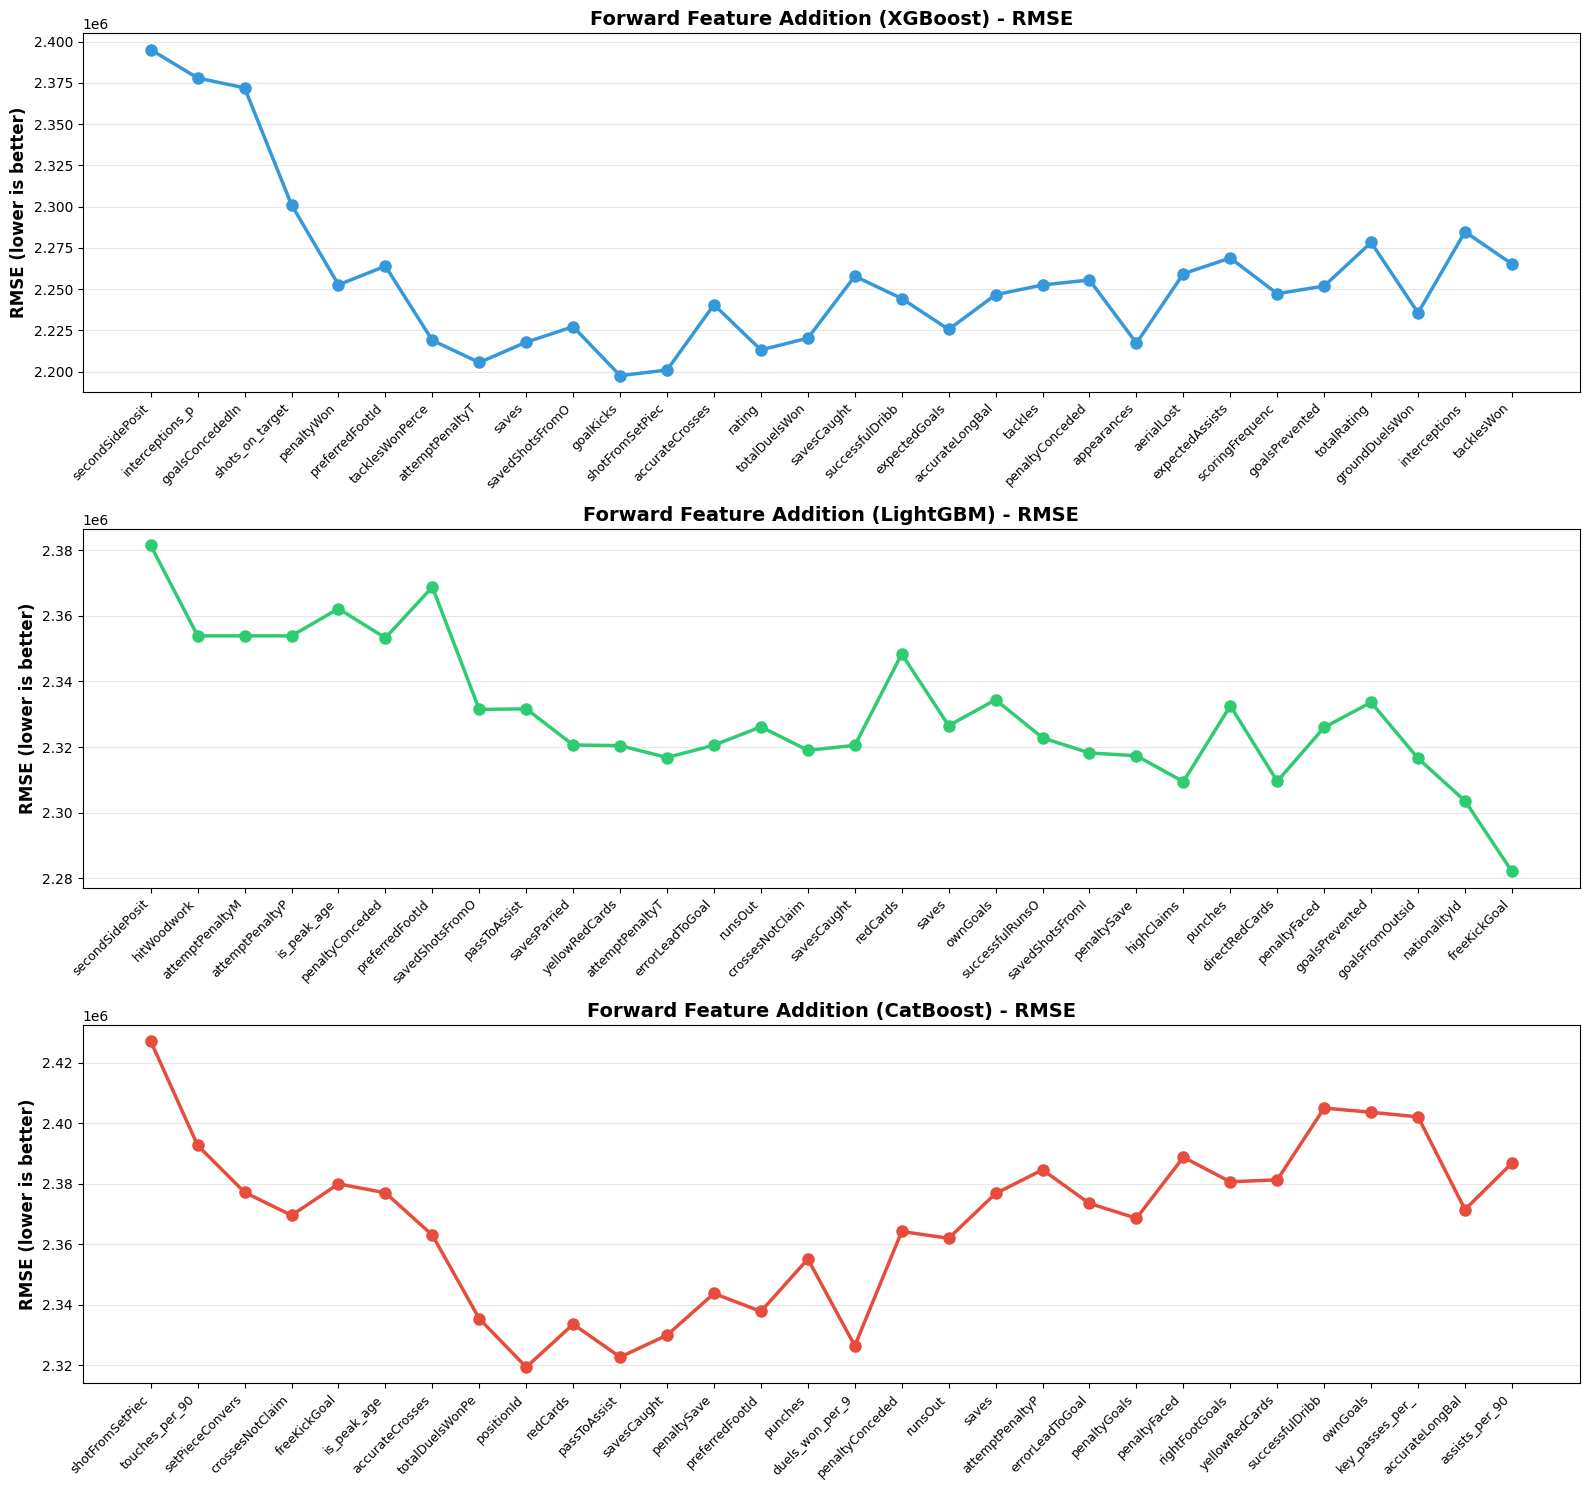

In [111]:
# Plot with feature names on x-axis (similar to the reference image) - RMSE
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

progressions = [
    (xgb_progression, 'XGBoost', '#3498db'),
    (lgbm_progression, 'LightGBM', '#2ecc71'),
    (catboost_progression, 'CatBoost', '#e74c3c')
]

for ax, (prog, name, color) in zip(axes, progressions):
    # Create x positions
    x_pos = range(len(prog))

    # Plot
    ax.plot(x_pos, prog['rmse'], marker='o', linewidth=2.5, markersize=8, color=color)
    ax.set_ylabel('RMSE (lower is better)', fontsize=12, fontweight='bold')
    ax.set_title(f'Forward Feature Addition ({name}) - RMSE', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Set x-axis with feature names
    ax.set_xticks(x_pos)
    feature_labels = [f"{feat[:15]}" for feat in prog['feature_added']]  # Truncate long names
    ax.set_xticklabels(feature_labels, rotation=45, ha='right', fontsize=9)

    # Best point (minimum RMSE)
    # best_idx = prog['rmse'].idxmin()
    # best_rmse = prog.loc[best_idx, 'rmse']
    # best_k = int(prog.loc[best_idx, 'n_features'])

    # ax.axhline(y=best_rmse, color='red', linestyle='--', linewidth=1, alpha=0.5)
    # ax.text(len(prog) - 1, best_rmse, f'Min: €{best_rmse:,.0f} @ {best_k} features',
    #         fontsize=10, ha='right', va='bottom', color='red')

plt.tight_layout()
plt.show()

In [109]:
y_test_pred_xgb_fs = xgb_fs_model.predict(X_test[xgb_selected])
xgb_test_results = eval_new(y_test_pred_xgb_fs, values_df_test, "XGBoost")
# y_pred_xgb_original = values_df_test['Predicted'].copy()

y_test_pred_lgbm_fs = lgbm_fs_model.predict(X_test[lgbm_selected])
lgbm_test_results = eval_new(y_test_pred_lgbm_fs, values_df_test, "LightGBM")
# y_pred_lgbm_original = values_df_test['Predicted'].copy()

y_test_pred_catboost_fs = catboost_fs_model.predict(X_test[catboost_selected])
catboost_test_results = eval_new(y_test_pred_catboost_fs, values_df_test, "CatBoost")
# y_pred_catboost_original = values_df_test['Predicted'].copy()


XGBoost Evaluation Results
  Log RMSE: 0.5847
  Log MAE:  0.2173
  Log R²:   0.8819
--------------------------------------------------
  RMSE: €2,300,785
  MAE: €953,495
  R²: 0.9678
  MAPE: 24664.27%

LightGBM Evaluation Results
  Log RMSE: 0.5832
  Log MAE:  0.2215
  Log R²:   0.8826
--------------------------------------------------
  RMSE: €2,325,463
  MAE: €1,003,144
  R²: 0.9671
  MAPE: 23124.03%

CatBoost Evaluation Results
  Log RMSE: 0.5785
  Log MAE:  0.2065
  Log R²:   0.8844
--------------------------------------------------
  RMSE: €2,085,356
  MAE: €893,799
  R²: 0.9736
  MAPE: 23622.54%
